In [1]:
# script to determine number of moves in a game

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import os
import sys
import warnings
warnings.filterwarnings('ignore')

In [3]:
def getMoves(board):
    moves = []
    for i in range(len(board)):
        for j in range(len(board[i])):
            if board[i][j] == 0:
                moves.append((i, j))
    return moves

def check_win(arr):
    
    if len(arr) == 3:
    
        if arr[0] == arr[1] == arr[2] == 1:
            return 1
        elif arr[0] == arr[1] == arr[2] == 2:
            return 2
        else:
            return False
        
    elif len(arr) == 4:

        if arr[0] == arr[1] == arr[2] == arr[3] == 1:
            return 1
        elif arr[0] == arr[1] == arr[2] == arr[3] == 2:
            return 2
        else:
            return False

    elif len(arr) == 5:
        
        if arr[0] == arr[1] == arr[2] == arr[3] == 1:
            return 1
        elif arr[1] == arr[2] == arr[3] == arr[4] == 1:
            return 1
        elif arr[0] == arr[1] == arr[2] == arr[3] == 2:
            return 2
        elif arr[1] == arr[2] == arr[3] == arr[4] == 2:
            return 2
        else:
            return False
        
def getWinner(board):
    # represent the board as an array for easier manipulation
    board_array = np.array(board)
    wins = []
    
    n = len(board)
    
    
    # iterate through columns to check for vertical wins
    for j in range(n):
        # slice each column, check for win
        winner = check_win(board_array[:, j])
        wins.append(winner)

    # iterate through rows to check for horizontal wins
    for i in range(n):
        # slice each row, check for win
        winner = check_win(board_array[i, :])
        wins.append(winner)

    # get diagonals of board
    # note: this approach identifies ALL diagonals in the board (not only those of length 3), handled later
    diags = [board_array[::-1, :].diagonal(i) for i in range(-board_array.shape[0] + 1, board_array.shape[1])]
    diags.extend(board_array.diagonal(i) for i in range(board_array.shape[1] - 1, -board_array.shape[0], -1))

    # only the main diagonal and anti diagonal can be used for a win, so check for win only in those
    for each in diags:
        if len(each) == 3:
            wins.append(check_win(each))
        else:
            if len(each) >= 4:
                wins.append(check_win(each))

    # remove all booleans, leaving only integer values (1 or 2) to indicate a winner
    wins2 = [win for win in wins if win]

    # if there is no integer in wins2 (no winner yet) and if there are no more valid moves, it's a tie (return 0)
    if not wins2:
        if len(getMoves(board)) == 0:
            return 0

    # if there is an integer in wins2, there is a winner. return the winner, else, there are still moves to be made (return -1)
    if wins2:
        return wins2[0]
    else:
        return -1

In [4]:
def parse_filename(filename):
    board_size = filename[0]
    parsed = filename.split("_")
    p1 = parsed[1]
    p2 = parsed[2]

    if "dnn" in p1:
        p1_model = "dnn"
    elif "minimax" in p1:
        p1_model = "minimax"

    if "dnn" in p2:
        p2_model = "dnn"
    elif "minimax" in p2:
        p2_model = "minimax"
        
    p1_model_level = int(p1[-1])
    p2_model_level = int(p2[-1])
        
    #return [filename, p1_model, p1_model_level, p2_model, p2_model_level]
    return [board_size, p1_model, p1_model_level, p2_model, p2_model_level]

In [5]:
def moves_per_player(filename):
    df = pd.read_csv(filename, header=None)
    df.columns = ["Previous State", "Next State", "Player", "Cyber Move", "Game ID"]
    
    if "/" in filename:
        board_size, p1_model, p1_model_level, p2_model, p2_model_level = parse_filename(filename.split("/")[-1])
    else:
        board_size, p1_model, p1_model_level, p2_model, p2_model_level = parse_filename(filename)
    
    data_dict = {}
    
    for each in np.unique(df["Game ID"]):
        frame = df[df["Game ID"] == each]
        total_nmoves = frame.shape[0]
        frame.reset_index(drop=True, inplace=True)
        
        moves = frame["Next State"].to_list()
        last_state = ast.literal_eval(moves[-1])
        winner = getWinner(last_state)
        
        #if winner != 0:
        # removing the above lines because if two minimax are playing, game always ends in tie
        p1_moves = frame["Player"].value_counts()[1]
        p2_moves = frame["Player"].value_counts()[2]
        
        data_dict[each] = [len(np.unique(df["Game ID"])), board_size, winner, p1_moves, p1_model, p1_model_level, p2_moves, p2_model, p2_model_level, total_nmoves]
        
    return data_dict

In [6]:
def generate_avg_moves_heatmap(filepath, player=-1, model1="minimax", model2="minimax"):
    
    #if player == 0:
    #    print("can't do ties right now sorry - nawal")
    #    sys.exit(0)
    
    all_data = []

    for file in os.listdir(filepath):
        if file.endswith(".csv"):
            
            if file[-1] == "/":
                data = moves_per_player(filename=f"{filepath}{file}")
            else:
                data = moves_per_player(filename=f"{filepath}/{file}")
            
            #data = moves_per_player(filename=)
            #print(i, file, len(data))
            all_data.append(data)
            
    arr = np.ndarray(shape=(6,6))
    arr2 = np.ndarray(shape=(6,6))
    arr.fill(0)
    arr2.fill(0)
    
    null_arr = np.ndarray(shape=(6,6))
    null_arr.fill(0)
    
    for each in all_data:
        for key in each:
            ngames, board_size, winner, p1_moves, p1_model, p1_model_level, p2_moves, p2_model, p2_model_level, total_nmoves = each[key]
            
            if p1_model == p2_model == model1 == model2:
                
                if player == -1:
                    arr[p1_model_level][p2_model_level] += int(total_nmoves)
                    
                elif player == 0 and winner == 0:
                    arr[p1_model_level][p2_model_level] += int(total_nmoves)
                    arr2[p1_model_level][p2_model_level] += 1
                    
                else:
                    if player == winner:
                        if winner == 1:
                            arr[p1_model_level][p2_model_level] += p1_moves
                            arr2[p1_model_level][p2_model_level] += 1
                        elif winner == 2:
                            arr[p1_model_level][p2_model_level] += p2_moves
                            arr2[p1_model_level][p2_model_level] += 1
                    
            elif p1_model == model1 and p2_model == model2:
                
                if player == -1:
                    arr[p1_model_level][p2_model_level] += int(total_nmoves)
                    
                elif player == 0 and winner == 0:
                    arr[p1_model_level][p2_model_level] += int(total_nmoves)
                    arr2[p1_model_level][p2_model_level] += 1
                    
                else:
                    if player == winner:
                        if winner == 1:
                            arr[p1_model_level][p2_model_level] += p1_moves
                            arr2[p1_model_level][p2_model_level] += 1
                        elif winner == 2:
                            arr[p1_model_level][p2_model_level] += p2_moves
                            arr2[p1_model_level][p2_model_level] += 1

    if player != -1:
        arr = arr/arr2
        arr = np.nan_to_num(arr)
    else:
        arr = arr/ngames
    
    if not np.array_equal(arr, null_arr):
        
        ax = plt.axes()
        
        if player > 0:
            ax.set_title(f"Average Number of Moves Per Game When Player {player} Wins ({ngames} games per cell)")
        elif player == 0:
            ax.set_title(f"Average Number of Moves In a Tie Game ({ngames} games per cell)")
        else:
             ax.set_title(f"Average Number of Moves Per Game ({ngames} games per cell)")

        ax = sns.heatmap(arr, annot=True, fmt=".3g", ax = ax, cmap="Blues")
        plt.xlabel(f"Defender Skill Level ({model2})")
        plt.ylabel(f"Attacker Skill Level ({model1})")


        #savefile = f"{board_size}x{board_size}_p1{model1}_p2{model2}_winner={player}.png"
        #savepath = f"./plots/nmoves/{savefile}"

        #plt.savefig(savepath, bbox_inches='tight')
        plt.show()


        min_indices = np.unravel_index(arr.argmin(), arr.shape)


        return arr

In [7]:
def get_numpy_min(arr, diagonals=False):
    
    arr = np.where(arr == 0.0, 100.0, arr)
    
    i, j = np.unravel_index(arr.argmin(), arr.shape)
    min_value = arr[i][j]
    
    print("Player 1 Skill: ", i)
    print("Player 2 Skill: ", j)
    print("Min. number of moves until win on average: ", min_value)
    
    if diagonals:
        # examining only main diagonal (both players at equal skill levels)
        print("------diagonals------")
        diags = np.diagonal(arr)
        i = diags.argmin()
        print("Both players at skill level: ", i)
        print("Min. number of moves until win on average: ", diags[i])
    
    #return min_value, [i, j]

In [8]:
def arr_avg(arr, diagonals=False):
    flat = np.ndarray.flatten(arr)
    non_zero = flat[flat != 0]
    print("Avg. Number of Moves Until Win: ", np.mean(non_zero))
    
    if diagonals:
        diags = np.diagonal(arr)
        non_zero = diags[diags != 0]
        print("Avg. Number of Moves Until Win (players at same skill level): ", np.mean(non_zero))

#### avg. number of moves in all games

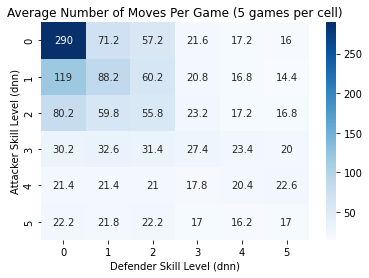

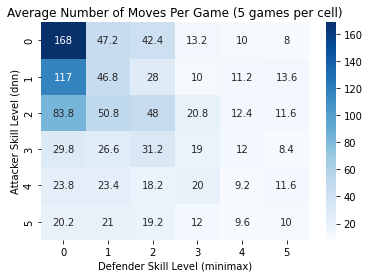

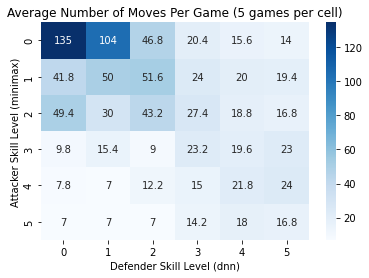

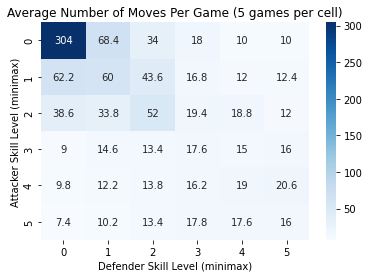

In [9]:
arr = generate_avg_moves_heatmap(filepath="./5x5_experiments/gameplay_5x5_experiments", model1="dnn", model2="dnn")
arr = generate_avg_moves_heatmap(filepath="./5x5_experiments/gameplay_5x5_experiments", model1="dnn", model2="minimax")
arr = generate_avg_moves_heatmap(filepath="./5x5_experiments/gameplay_5x5_experiments", model1="minimax", model2="dnn")
arr = generate_avg_moves_heatmap(filepath="./5x5_experiments/gameplay_5x5_experiments", model1="minimax", model2="minimax")

In [10]:
# what algorithm won in the smallest number of moves?
# what algorithm won in the most number of moves?

#### 1 - avg. number of moves when player 1 wins

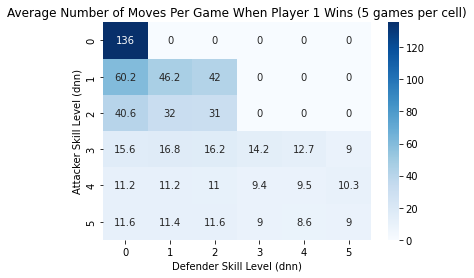

Avg. Number of Moves Until Win:  23.834
Avg. Number of Moves Until Win (players at same skill level):  40.90833333333333


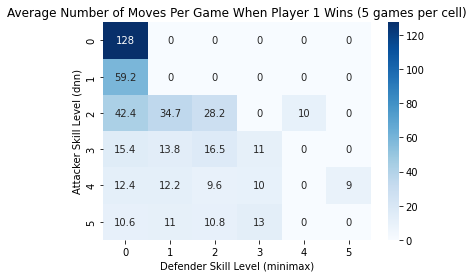

Avg. Number of Moves Until Win:  24.066666666666666
Avg. Number of Moves Until Win (players at same skill level):  55.583333333333336


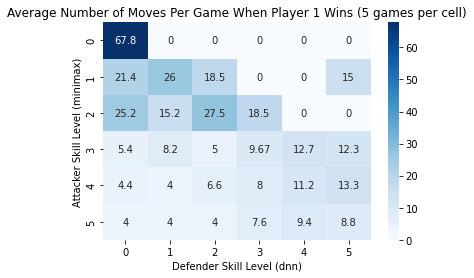

Avg. Number of Moves Until Win:  13.842592592592595
Avg. Number of Moves Until Win (players at same skill level):  25.16111111111111


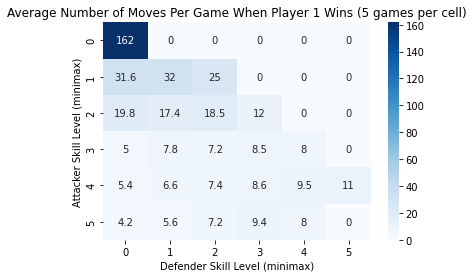

Avg. Number of Moves Until Win:  18.22708333333333
Avg. Number of Moves Until Win (players at same skill level):  46.05


In [11]:
arr = generate_avg_moves_heatmap(filepath="./5x5_experiments/gameplay_5x5_experiments", player=1, model1="dnn", model2="dnn")
#get_numpy_min(arr, diagonals=True)
arr_avg(arr, diagonals=True)

arr = generate_avg_moves_heatmap(filepath="./5x5_experiments/gameplay_5x5_experiments", player=1, model1="dnn", model2="minimax")
#get_numpy_min(arr, diagonals=True)
arr_avg(arr, diagonals=True)

arr = generate_avg_moves_heatmap(filepath="./5x5_experiments/gameplay_5x5_experiments", player=1, model1="minimax", model2="dnn")
#get_numpy_min(arr, diagonals=True)
arr_avg(arr, diagonals=True)

arr = generate_avg_moves_heatmap(filepath="./5x5_experiments/gameplay_5x5_experiments", player=1, model1="minimax", model2="minimax")
#get_numpy_min(arr, diagonals=True)
arr_avg(arr, diagonals=True)

considering only when player 1 wins:<br>
p1 as minimax algorithm makes less moves as p1 as dnn algorithm to win a game, on average (13.84)<br>
when both players are at the same skill level, p1 as minimax outplays p2 as dnn (25.2 moves on average to win). this average figure is at its maximum when p1 is dnn and p2 is minimax. this suggests that the minimax algorithm makes good blocking moves to deter p1 from winning, and also possibly that p1 is hindered significantly by the chaos agent due to low-level skill play moves skewing the average figure

#### 2 - avg. number of moves when player 2 wins

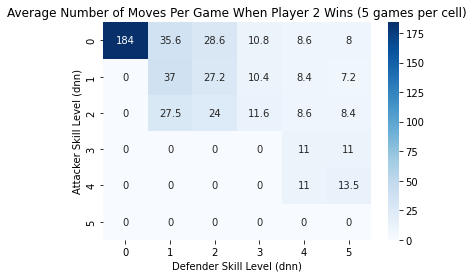

Avg. Number of Moves Until Win:  24.6225
Avg. Number of Moves Until Win (players at same skill level):  64.0


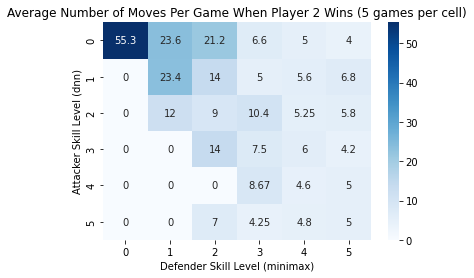

Avg. Number of Moves Until Win:  10.51851851851852
Avg. Number of Moves Until Win (players at same skill level):  17.47222222222222


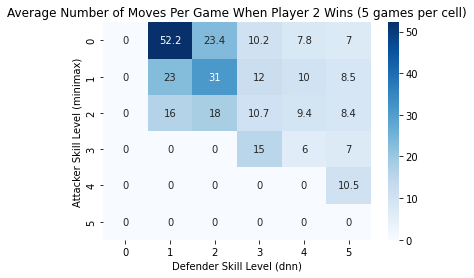

Avg. Number of Moves Until Win:  15.056140350877193
Avg. Number of Moves Until Win (players at same skill level):  18.666666666666668


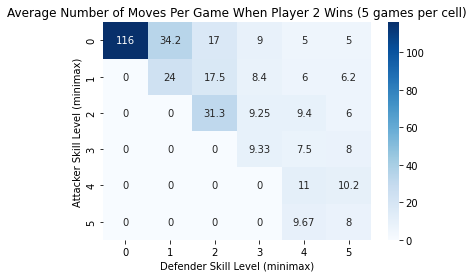

Avg. Number of Moves Until Win:  16.72878787878788
Avg. Number of Moves Until Win (players at same skill level):  33.27777777777778


In [12]:
arr = generate_avg_moves_heatmap(filepath="./5x5_experiments/gameplay_5x5_experiments", player=2, model1="dnn", model2="dnn")
#get_numpy_min(arr, diagonals=True)
arr_avg(arr, diagonals=True)

arr = generate_avg_moves_heatmap(filepath="./5x5_experiments/gameplay_5x5_experiments", player=2, model1="dnn", model2="minimax")
#get_numpy_min(arr, diagonals=True)
arr_avg(arr, diagonals=True)

arr = generate_avg_moves_heatmap(filepath="./5x5_experiments/gameplay_5x5_experiments", player=2, model1="minimax", model2="dnn")
#get_numpy_min(arr, diagonals=True)
arr_avg(arr, diagonals=True)

arr = generate_avg_moves_heatmap(filepath="./5x5_experiments/gameplay_5x5_experiments", player=2, model1="minimax", model2="minimax")
#get_numpy_min(arr, diagonals=True)
arr_avg(arr, diagonals=True)

In [13]:
# considering only when player 2 wins:
# the minimax algorithm wins in the LEAST amount of moves with 4 moves per game on average
# the dnn algorithm wins in the MOST amount of moves with 7.2 moves per game on average
# this is on par with my expectations, since we know that the minimax algorithm is generally better than the dnn

considering only when player 2 wins:<br>
p2 as minimax algorithm makes less moves as p1 as dnn algorithm to win a game, on average (10.5 moves/game)<br>
when both players are at the same skill level, p2 as minimax outplays p1 as dnn (17.5 moves on average to win). this average figure is at its maximum when both players are dnn.

#### 3 - avg. number of moves when game is tied

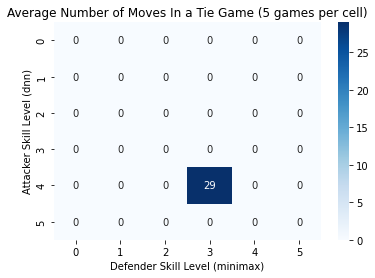

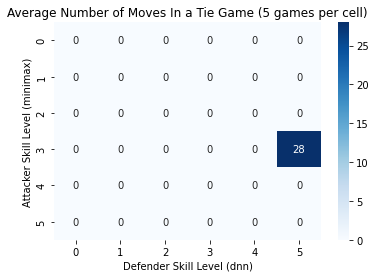

In [14]:
arr = generate_avg_moves_heatmap(filepath="./5x5_experiments/gameplay_5x5_experiments", player=0, model1="dnn", model2="dnn")
arr = generate_avg_moves_heatmap(filepath="./5x5_experiments/gameplay_5x5_experiments", player=0, model1="dnn", model2="minimax")
arr = generate_avg_moves_heatmap(filepath="./5x5_experiments/gameplay_5x5_experiments", player=0, model1="minimax", model2="dnn")
arr = generate_avg_moves_heatmap(filepath="./5x5_experiments/gameplay_5x5_experiments", player=0, model1="minimax", model2="minimax")

<strong>note: arrays with all elements = 0 are supressed and not shown</strong>

interestingly, not many games are tied in 5x5 tic tac toe. ties only occur when the two player's models are not the same. for p1 = dnn and p2 = minimax, a lesser skilled minimax algorithm (3) is able to tie a game with a slightly higher skilled dnn
algorithm (4). the same pattern is seen when p1 = minimax and p2 = dnn, with a slightly larger difference in skill level (p1 = 3, p2 = 5).

to me, this suggests that even at a disadvantage due to skill differences, the minimax algorithm tends to make better moves than the dnn. for example, consider figures 2 and 3 from section 1, where the algorithms for the two players differ. the p1 dnn algorithm tends to win for p2 skill = 3 and lower (figure 2); however, when p1 employs minimax, the p1 minimax algorithm consistently wins across the board for any p2 skill. this further bolsters that the minimax algorithm tends to make better moves than the dnn even with disadvantages due to skill level difference.

additionally, the minimax algorithm wins in the least amount of moves on average per game (see markdown boxes at end of sections 1 and 2) in the cases considering wins only for player 1 and player 2 separately. the dnn on the other hand always takes more moves than the minimax algorithm to produce a win.

# test

In [15]:
#x = moves_per_player(filename="./5x5_experiments/gameplay_5x5_experiments/5x5game_p1dnn5_p2minimax3_2022_04_22-04_57_42_AM.csv")

In [16]:
#for each in x:
#    ngames, board_size, winner, p1_moves, p1_model, p1_model_level, p2_moves, p2_model, p2_model_level, total_nmoves = x[each]
#    if p1_model_level == 5 and p2_model_level == 3:
#        if p1_model == "dnn" and p2_model == "minimax":
#            print(winner, p1_moves, p2_moves)

In [17]:
#df = pd.read_csv("./5x5_experiments/gameplay_5x5_experiments/5x5game_p1dnn5_p2minimax2_2022_04_22-05_05_14_AM.csv", header=None)
#df.columns = ["Previous State", "Next State", "Player", "Cyber Move", "Game ID"]

In [18]:
#df.shape

In [19]:
#df.shape[0]/df.shape[1]

In [20]:
#for each in np.unique(df["Game ID"]):
#    game = df[df["Game ID"] == each]
#    last_state = ast.literal_eval(game["Next State"].to_list()[-1])
#    winner = getWinner(last_state)
#    
#    print(np.array(last_state))
#    print(winner)